# Mouse Deletion Analysis — Inner Ear Cell Type

Predicts contact map changes from insulator deletions using AlphaGenome.

**Regions (mm10):**
- Jingyun: `chr13:83,739,797-83,745,138`
- Edward: `chr12:27,333,532-27,336,455`

**Cell type:** `UBERON:0001846` (inner ear)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv

from alphagenome.data import genome, gene_annotation, transcript
from alphagenome.models import dna_client

load_dotenv()
API_KEY = os.getenv('ALPHA_GENOME_API_KEY')

dna_model = dna_client.create(API_KEY)
print('Model initialized.')

Model initialized.


## 1. Check available mouse contact map cell types

There are only 8 mouse contact map tracks. Verify `UBERON:0001846` is available before running predictions.

In [13]:
mouse_meta = dna_model.output_metadata(dna_client.Organism.MUS_MUSCULUS).concatenate()
mouse_contact = mouse_meta[mouse_meta['output_type'] == dna_client.OutputType.CONTACT_MAPS]

print('All available mouse contact map cell types:')
display(mouse_contact[['ontology_curie', 'biosample_name', 'biosample_type']].reset_index(drop=True))

CELL_TYPE = 'UBERON:0001846'
available = CELL_TYPE in mouse_contact['ontology_curie'].values
print(f'\n{CELL_TYPE} available: {available}')

if not available:
    print('\nInner ear not available. Defaulting to olfactory receptor cell (CL:0000207)')
    print('— closest proxy: both are primary sensory neurons from cranial placodes.')
    CELL_TYPE = 'CL:0000207'

All available mouse contact map cell types:


,ontology_curie,biosample_name,biosample_type
0,CL:0000207,olfactory receptor cell,primary_cell
1,EFO:0001640,B cell derived cell line,primary_cell
2,EFO:0001640,B cell derived cell line,primary_cell
3,EFO:0004038,mouse embryonic stem cell,cell_line
4,CL:0000207,olfactory receptor cell,primary_cell
5,EFO:0005484,46C,cell_line
6,CL:0000207,olfactory receptor cell,primary_cell
7,CL:0000945,lymphocyte of B lineage,cell_line



UBERON:0001846 available: False

Inner ear not available. Defaulting to olfactory receptor cell (CL:0000207)
— closest proxy: both are primary sensory neurons from cranial placodes.


## 2. Load mouse gene annotations (mm10, GENCODE M23)

In [8]:
print('Loading mouse gene annotations (mm10)...')
gtf_url = (
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'mm10/gencode.vM23.annotation.gtf.gz.feather'
)
gtf = pd.read_feather(gtf_url)

gtf_transcript = gene_annotation.filter_transcript_support_level(
    gene_annotation.filter_protein_coding(gtf), ['1', '2']
)
gtf_longest = gene_annotation.filter_to_longest_transcript(gtf_transcript)
longest_extractor = transcript.TranscriptExtractor(gtf_longest)
longest_extractor.cache_transcripts()

print('Done.')

Loading mouse gene annotations (mm10)...
Done.


## 3. Define helper function

In [14]:
def run_deletion_analysis(chrom, deletion_start, deletion_end, cell_type, label):
    """
    Predict wild-type and deletion contact maps for a mouse region.
    
    chrom          : e.g. 'chr13'
    deletion_start : 1-based start coordinate (mm10)
    deletion_end   : 1-based end coordinate (mm10)
    cell_type      : ontology CURIE string, or None for all tracks
    label          : used in plot title and output filename
    """
    deletion_len = deletion_end - deletion_start + 1
    print(f'\n{"="*70}')
    print(f'{label}: {chrom}:{deletion_start:,}-{deletion_end:,} ({deletion_len:,} bp)')
    print(f'Cell type: {cell_type}')
    print(f'{"="*70}')

    # Build a 1 MB window centred on the deletion
    mid = (deletion_start + deletion_end) // 2
    half = 2**19  # 524,288 bp
    interval = genome.Interval(
        chromosome=chrom,
        start=max(0, mid - half),
        end=mid + half
    )
    print(f'Analysis window: {interval}')

    # Gene annotations
    print('Fetching gene annotations...')
    transcripts = longest_extractor.extract(interval)
    print(f'  {len(transcripts)} transcripts found')

    # Ontology terms argument
    ont_terms = [cell_type] if cell_type else None

    # Wild-type prediction
    print('Predicting wild-type...')
    wt = dna_model.predict_interval(
        interval=interval,
        requested_outputs={dna_client.OutputType.CONTACT_MAPS},
        ontology_terms=ont_terms,
        organism=dna_client.Organism.MUS_MUSCULUS,
    )
    wt_matrix = wt.contact_maps.values[:, :, 0]
    print(f'  WT matrix shape: {wt_matrix.shape}')

    # Deletion variant (position is 0-based)
    variant = genome.Variant(
        chromosome=chrom,
        position=deletion_start - 1,
        reference_bases='N' * deletion_len,
        alternate_bases='N',
    )

    # Deletion prediction
    print('Predicting deletion variant...')
    try:
        del_out = dna_model.predict_variant(
            interval=interval,
            variant=variant,
            requested_outputs={dna_client.OutputType.CONTACT_MAPS},
            ontology_terms=ont_terms,
            organism=dna_client.Organism.MUS_MUSCULUS,
        )
        del_matrix = del_out.alternate.contact_maps.values[:, :, 0]
        diff_matrix = del_matrix - wt_matrix
        has_deletion = True
        print(f'  Deletion matrix shape: {del_matrix.shape}')
    except Exception as e:
        print(f'  Deletion prediction failed: {e}')
        has_deletion = False

    # ── Plot ──────────────────────────────────────────────────────────────
    n_cols = 3 if has_deletion else 1
    fig = plt.figure(figsize=(6 * n_cols + 2, 10))

    # Row layout: gene track (top) + contact maps (bottom)
    gs = fig.add_gridspec(2, n_cols, height_ratios=[1, 4], hspace=0.35, wspace=0.3)

    # Gene annotation track
    ax_genes = fig.add_subplot(gs[0, :])
    for tx in transcripts:
        ti = tx.transcript_interval
        ax_genes.plot([ti.start, ti.end], [0.5, 0.5], color='steelblue', lw=2)
        name = tx.info.get('gene_name', '')
        if name:
            ax_genes.text((ti.start + ti.end) / 2, 0.62, name,
                          ha='center', va='bottom', fontsize=7, fontweight='bold')
    ax_genes.axvspan(deletion_start, deletion_end, alpha=0.25, color='red', label='Deletion')
    ax_genes.set_xlim(interval.start, interval.end)
    ax_genes.set_ylim(0, 1)
    ax_genes.set_yticks([])
    ax_genes.legend(loc='upper right', frameon=True, fontsize=8)
    ax_genes.set_title(
        f'{label}  |  {chrom}:{deletion_start:,}-{deletion_end:,}  |  cell type: {cell_type}',
        fontsize=11, fontweight='bold'
    )
    ax_genes.ticklabel_format(style='plain', axis='x')
    for spine in ['top', 'right', 'left']:
        ax_genes.spines[spine].set_visible(False)

    extent = [interval.start, interval.end, interval.end, interval.start]
    vmax = np.percentile(wt_matrix, 99)

    def _contact_ax(ax, matrix, title, cmap='Reds', vmin=0, vmax_val=None):
        im = ax.imshow(matrix, cmap=cmap, aspect='auto',
                       interpolation='nearest', extent=extent,
                       vmin=vmin, vmax=vmax_val or np.percentile(matrix, 99))
        ax.axhline(deletion_start, color='cyan', lw=1.2, ls='--', alpha=0.8)
        ax.axhline(deletion_end,   color='cyan', lw=1.2, ls='--', alpha=0.8)
        ax.axvline(deletion_start, color='cyan', lw=1.2, ls='--', alpha=0.8)
        ax.axvline(deletion_end,   color='cyan', lw=1.2, ls='--', alpha=0.8)
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.ticklabel_format(style='plain')
        ax.set_xlabel('Position (bp)')
        ax.set_ylabel('Position (bp)')
        return im

    # Wild-type
    ax_wt = fig.add_subplot(gs[1, 0])
    im_wt = _contact_ax(ax_wt, wt_matrix, 'Wild-type', vmax_val=vmax)
    plt.colorbar(im_wt, ax=ax_wt, label='Contact freq.', shrink=0.8)

    if has_deletion:
        # Deletion
        ax_del = fig.add_subplot(gs[1, 1])
        im_del = _contact_ax(ax_del, del_matrix, f'After deletion ({deletion_len:,} bp)', vmax_val=vmax)
        plt.colorbar(im_del, ax=ax_del, label='Contact freq.', shrink=0.8)

        # Difference map
        ax_diff = fig.add_subplot(gs[1, 2])
        vlim = np.percentile(np.abs(diff_matrix), 99)
        im_diff = _contact_ax(ax_diff, diff_matrix, 'Deletion − WT (difference)',
                               cmap='RdBu_r', vmin=-vlim, vmax_val=vlim)
        plt.colorbar(im_diff, ax=ax_diff, label='Δ Contact freq.', shrink=0.8)

    safe = f'{chrom}_{deletion_start}_{deletion_end}'
    out_path = f'../media/mouse_deletion_{safe}.png'
    plt.savefig(out_path, dpi=200, bbox_inches='tight')
    print(f'Saved: {out_path}')
    plt.show()
    plt.close()
    return wt_matrix, (del_matrix if has_deletion else None)

In [15]:
def run_deletion_analysis(chrom, deletion_start, deletion_end, cell_type, label):
    """
    Predict wild-type and deletion contact maps for a mouse region.
    Returns (wt_matrix, del_matrix, interval).
    """
    deletion_len = deletion_end - deletion_start + 1
    print(f'\n{"="*70}')
    print(f'{label}: {chrom}:{deletion_start:,}-{deletion_end:,} ({deletion_len:,} bp)')
    print(f'Cell type: {cell_type}')
    print(f'{"="*70}')

    mid = (deletion_start + deletion_end) // 2
    half = 2**19
    interval = genome.Interval(
        chromosome=chrom,
        start=max(0, mid - half),
        end=mid + half
    )
    print(f'Analysis window: {interval}')

    print('Fetching gene annotations...')
    transcripts = longest_extractor.extract(interval)
    print(f'  {len(transcripts)} transcripts found')

    ont_terms = [cell_type] if cell_type else None

    print('Predicting wild-type...')
    wt = dna_model.predict_interval(
        interval=interval,
        requested_outputs={dna_client.OutputType.CONTACT_MAPS},
        ontology_terms=ont_terms,
        organism=dna_client.Organism.MUS_MUSCULUS,
    )
    wt_matrix = wt.contact_maps.values[:, :, 0]
    print(f'  WT matrix shape: {wt_matrix.shape}')

    variant = genome.Variant(
        chromosome=chrom,
        position=deletion_start - 1,
        reference_bases='N' * deletion_len,
        alternate_bases='N',
    )

    print('Predicting deletion variant...')
    try:
        del_out = dna_model.predict_variant(
            interval=interval,
            variant=variant,
            requested_outputs={dna_client.OutputType.CONTACT_MAPS},
            ontology_terms=ont_terms,
            organism=dna_client.Organism.MUS_MUSCULUS,
        )
        del_matrix = del_out.alternate.contact_maps.values[:, :, 0]
        diff_matrix = del_matrix - wt_matrix
        has_deletion = True
        print(f'  Deletion matrix shape: {del_matrix.shape}')
    except Exception as e:
        print(f'  Deletion prediction failed: {e}')
        has_deletion = False
        del_matrix = None
        diff_matrix = None

    # ── 3-panel plot (WT | Deletion | Difference) ────────────────────────
    n_cols = 3 if has_deletion else 1
    fig = plt.figure(figsize=(6 * n_cols + 2, 10))
    gs = fig.add_gridspec(2, n_cols, height_ratios=[1, 4], hspace=0.35, wspace=0.3)

    ax_genes = fig.add_subplot(gs[0, :])
    for tx in transcripts:
        ti = tx.transcript_interval
        ax_genes.plot([ti.start, ti.end], [0.5, 0.5], color='steelblue', lw=2)
        name = tx.info.get('gene_name', '')
        if name:
            ax_genes.text((ti.start + ti.end) / 2, 0.62, name,
                          ha='center', va='bottom', fontsize=7, fontweight='bold')
    ax_genes.axvspan(deletion_start, deletion_end, alpha=0.25, color='red', label='Deletion')
    ax_genes.set_xlim(interval.start, interval.end)
    ax_genes.set_ylim(0, 1)
    ax_genes.set_yticks([])
    ax_genes.legend(loc='upper right', frameon=True, fontsize=8)
    ax_genes.set_title(
        f'{label}  |  {chrom}:{deletion_start:,}-{deletion_end:,}  |  cell type: {cell_type}',
        fontsize=11, fontweight='bold'
    )
    ax_genes.ticklabel_format(style='plain', axis='x')
    for spine in ['top', 'right', 'left']:
        ax_genes.spines[spine].set_visible(False)

    extent = [interval.start, interval.end, interval.end, interval.start]
    vmax = np.percentile(wt_matrix, 99)

    def _contact_ax(ax, matrix, title, cmap='Reds', vmin=0, vmax_val=None):
        im = ax.imshow(matrix, cmap=cmap, aspect='auto',
                       interpolation='nearest', extent=extent,
                       vmin=vmin, vmax=vmax_val or np.percentile(matrix, 99))
        ax.axhline(deletion_start, color='cyan', lw=1.2, ls='--', alpha=0.8)
        ax.axhline(deletion_end,   color='cyan', lw=1.2, ls='--', alpha=0.8)
        ax.axvline(deletion_start, color='cyan', lw=1.2, ls='--', alpha=0.8)
        ax.axvline(deletion_end,   color='cyan', lw=1.2, ls='--', alpha=0.8)
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.ticklabel_format(style='plain')
        ax.set_xlabel('Position (bp)')
        ax.set_ylabel('Position (bp)')
        return im

    ax_wt = fig.add_subplot(gs[1, 0])
    im_wt = _contact_ax(ax_wt, wt_matrix, 'Wild-type', vmax_val=vmax)
    plt.colorbar(im_wt, ax=ax_wt, label='Contact freq.', shrink=0.8)

    if has_deletion:
        ax_del = fig.add_subplot(gs[1, 1])
        im_del = _contact_ax(ax_del, del_matrix, f'After deletion ({deletion_len:,} bp)', vmax_val=vmax)
        plt.colorbar(im_del, ax=ax_del, label='Contact freq.', shrink=0.8)

        ax_diff = fig.add_subplot(gs[1, 2])
        vlim = np.percentile(np.abs(diff_matrix), 99)
        im_diff = _contact_ax(ax_diff, diff_matrix, 'Deletion − WT (difference)',
                               cmap='RdBu_r', vmin=-vlim, vmax_val=vlim)
        plt.colorbar(im_diff, ax=ax_diff, label='Δ Contact freq.', shrink=0.8)

    safe = f'{chrom}_{deletion_start}_{deletion_end}'
    out_path = f'../media/mouse_deletion_{safe}.png'
    plt.savefig(out_path, dpi=200, bbox_inches='tight')
    print(f'Saved: {out_path}')
    plt.show()
    plt.close()

    return wt_matrix, del_matrix, interval


Jingyun's insulator deletion: chr13:83,739,797-83,745,138 (5,342 bp)
Cell type: CL:0000207
Analysis window: chr13:83218179-84266755:.
Fetching gene annotations...
  1 transcripts found
Predicting wild-type...
  WT matrix shape: (512, 512)
Predicting deletion variant...
  Deletion matrix shape: (512, 512)
Saved: ../media/mouse_deletion_chr13_83739797_83745138.png


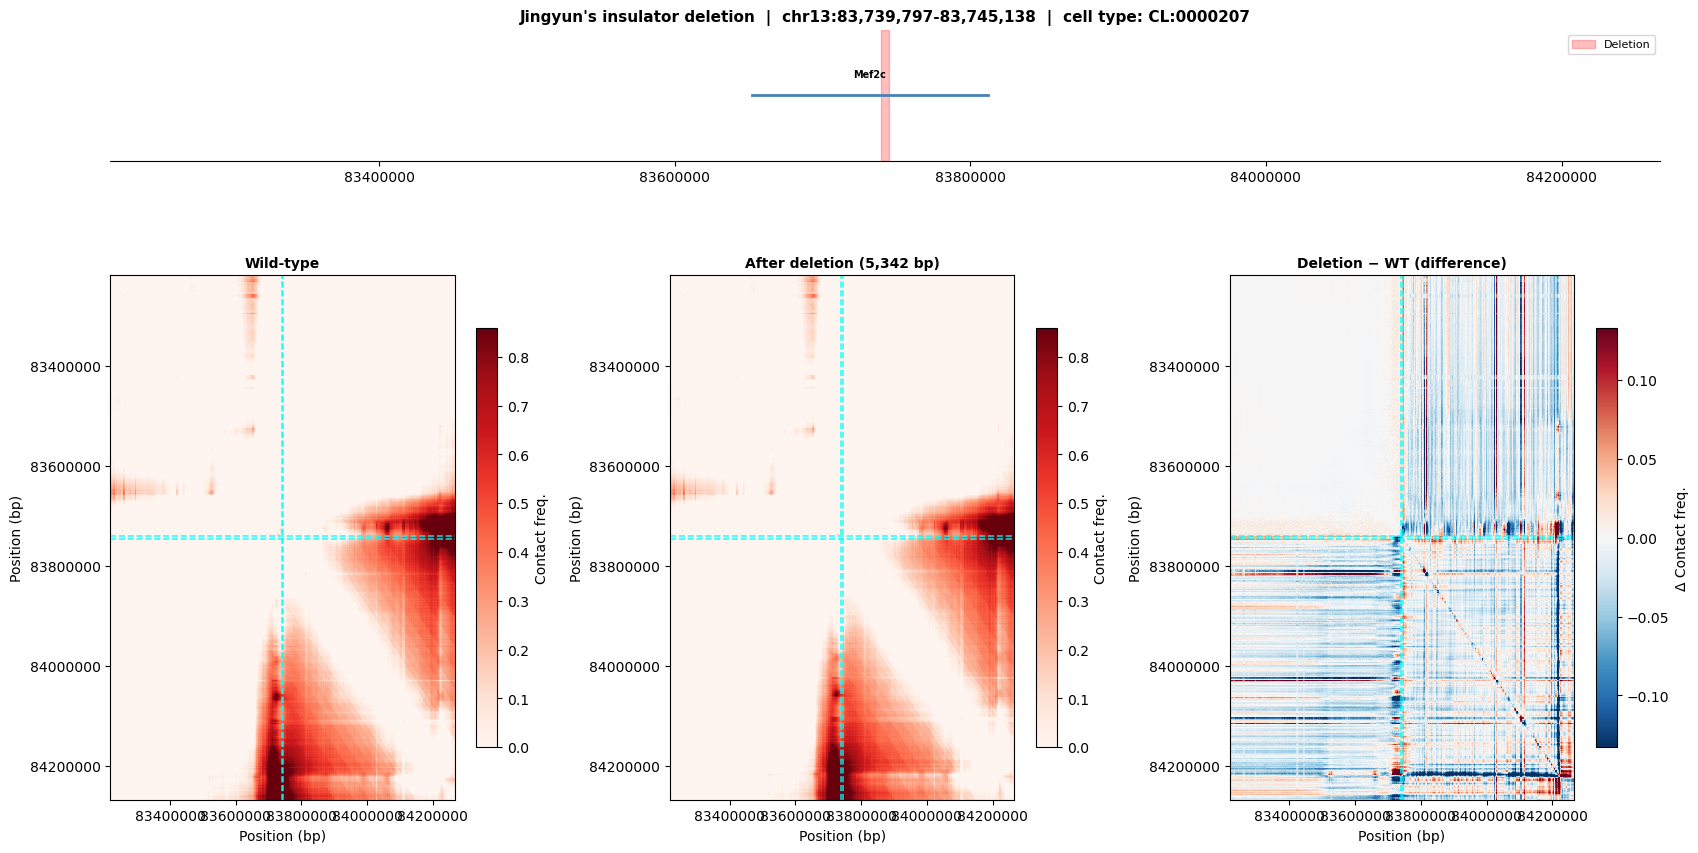

ValueError: too many values to unpack (expected 2)

In [16]:
wt1, del1 = run_deletion_analysis(
    chrom='chr13',
    deletion_start=83_739_797,
    deletion_end=83_745_138,
    cell_type=CELL_TYPE,
    label="Jingyun's insulator deletion"
)

In [ ]:
wt1, del1, interval1 = run_deletion_analysis(
    chrom='chr13',
    deletion_start=83_739_797,
    deletion_end=83_745_138,
    cell_type=CELL_TYPE,
    label="Jingyun's insulator deletion"
)


Edward's insulator deletion: chr12:27,333,532-27,336,455 (2,924 bp)
Cell type: CL:0000207
Analysis window: chr12:26810705-27859281:.
Fetching gene annotations...
  0 transcripts found
Predicting wild-type...
  WT matrix shape: (512, 512)
Predicting deletion variant...
  Deletion matrix shape: (512, 512)
Saved: ../media/mouse_deletion_chr12_27333532_27336455.png


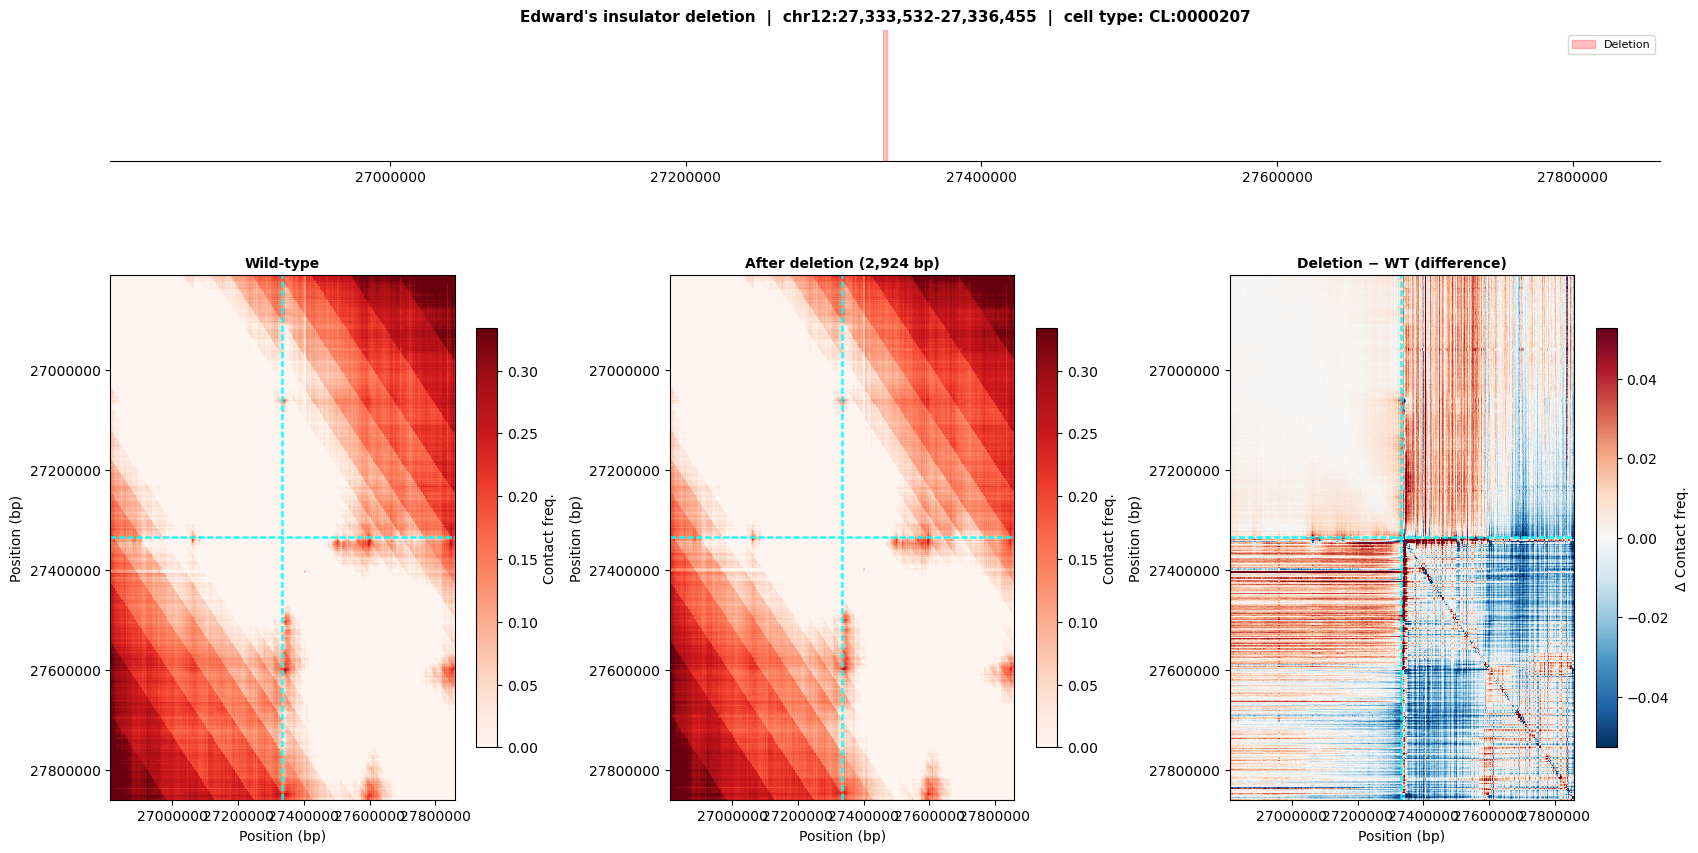

In [ ]:
wt2, del2 = run_deletion_analysis(
    chrom='chr12',
    deletion_start=27_333_532,
    deletion_end=27_336_455,
    cell_type=CELL_TYPE,
    label="Edward's insulator deletion"
)

In [ ]:
wt2, del2, interval2 = run_deletion_analysis(
    chrom='chr12',
    deletion_start=27_333_532,
    deletion_end=27_336_455,
    cell_type=CELL_TYPE,
    label="Edward's insulator deletion"
)

## 6. Extra visualizations: log2 ratio, virtual 4C, P(s) curve

In [ ]:
def plot_extra_analyses(wt_matrix, del_matrix, interval, deletion_start, deletion_end, label, chrom):
    """
    Three additional plots per region:
      1. Log2 ratio map  — cleaner fold-change view of gained/lost contacts
      2. Virtual 4C       — 1D contact profile from the insulator, WT vs deletion
      3. P(s) curve       — contact probability vs genomic distance
    """
    if del_matrix is None:
        print(f'{label}: no deletion matrix, skipping extra analysis.')
        return

    n_bins = wt_matrix.shape[0]
    bin_size = (interval.end - interval.start) / n_bins
    positions = np.linspace(interval.start, interval.end, n_bins)

    # Log2 ratio (deletion / WT)
    eps = 1e-6
    log2_ratio = np.log2((del_matrix + eps) / (wt_matrix + eps))

    # Virtual 4C: row through the centre of the deletion
    del_center = (deletion_start + deletion_end) // 2
    del_bin = int((del_center - interval.start) / bin_size)
    del_bin = np.clip(del_bin, 0, n_bins - 1)
    v4c_wt  = wt_matrix[del_bin, :]
    v4c_del = del_matrix[del_bin, :]

    # P(s): mean contact freq at each diagonal offset
    max_dist_bins = n_bins // 2
    distances_kb = np.arange(1, max_dist_bins) * bin_size / 1e3
    ps_wt  = np.array([np.nanmean(np.diag(wt_matrix,  k)) for k in range(1, max_dist_bins)])
    ps_del = np.array([np.nanmean(np.diag(del_matrix, k)) for k in range(1, max_dist_bins)])

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'{label} — Additional Analysis\n{chrom}:{deletion_start:,}–{deletion_end:,}',
                 fontsize=12, fontweight='bold')

    extent = [interval.start, interval.end, interval.end, interval.start]

    # ── Log2 ratio map ────────────────────────────────────────────────────
    ax = axes[0]
    vlim = np.percentile(np.abs(log2_ratio), 99)
    im = ax.imshow(log2_ratio, cmap='RdBu_r', aspect='auto',
                   interpolation='nearest', extent=extent, vmin=-vlim, vmax=vlim)
    for coord in [deletion_start, deletion_end]:
        ax.axhline(coord, color='black', lw=1, ls='--', alpha=0.6)
        ax.axvline(coord, color='black', lw=1, ls='--', alpha=0.6)
    plt.colorbar(im, ax=ax, label='log₂(deletion / WT)', shrink=0.8)
    ax.set_title('Log₂ Ratio Map\n(red = gained contacts, blue = lost)', fontsize=10, fontweight='bold')
    ax.ticklabel_format(style='plain')
    ax.set_xlabel('Position (bp)')
    ax.set_ylabel('Position (bp)')

    # ── Virtual 4C ───────────────────────────────────────────────────────
    ax = axes[1]
    ax.fill_between(positions, v4c_wt, alpha=0.2, color='steelblue')
    ax.plot(positions, v4c_wt,  color='steelblue', lw=1.5, label='Wild-type')
    ax.fill_between(positions, v4c_del, alpha=0.2, color='firebrick')
    ax.plot(positions, v4c_del, color='firebrick', lw=1.5, label='Deletion', alpha=0.8)
    ax.axvspan(deletion_start, deletion_end, alpha=0.12, color='red')
    ax.axvline(del_center, color='gray', lw=1, ls=':', alpha=0.7, label='Viewpoint')
    ax.set_title(f'Virtual 4C from deletion site\n(row through bin {del_bin})', fontsize=10, fontweight='bold')
    ax.set_xlabel('Genomic position (bp)')
    ax.set_ylabel('Contact frequency')
    ax.legend(fontsize=8)
    ax.ticklabel_format(style='plain', axis='x')

    # ── P(s) curve ───────────────────────────────────────────────────────
    ax = axes[2]
    ax.loglog(distances_kb, ps_wt,  color='steelblue', lw=1.5, label='Wild-type')
    ax.loglog(distances_kb, ps_del, color='firebrick', lw=1.5, label='Deletion', alpha=0.8)
    # shade the difference
    ax.fill_between(distances_kb,
                    np.minimum(ps_wt, ps_del),
                    np.maximum(ps_wt, ps_del),
                    alpha=0.15, color='purple', label='Δ region')
    ax.set_title('Contact frequency vs. distance P(s)\n(log–log scale)', fontsize=10, fontweight='bold')
    ax.set_xlabel('Genomic distance (kb)')
    ax.set_ylabel('Mean contact frequency')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, which='both')

    plt.tight_layout()

    safe = f'{chrom}_{deletion_start}_{deletion_end}'
    out_path = f'../media/mouse_deletion_{safe}_extra.png'
    plt.savefig(out_path, dpi=200, bbox_inches='tight')
    print(f'Saved: {out_path}')
    plt.show()
    plt.close()

In [ ]:
plot_extra_analyses(wt1, del1, interval1,
                    deletion_start=83_739_797, deletion_end=83_745_138,
                    label="Jingyun's insulator deletion", chrom='chr13')

In [ ]:
plot_extra_analyses(wt2, del2, interval2,
                    deletion_start=27_333_532, deletion_end=27_336_455,
                    label="Edward's insulator deletion", chrom='chr12')